In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [209]:
data = pd.read_excel('data/Education.xls', skiprows=range(4), usecols=['FIPS Code',
                                                'State', 'Area name',
                                                'Percent of adults with less than a high school diploma, 2012-2016',
                                                'Percent of adults with a bachelor\'s degree or higher, 2012-2016'],
                        converters={'FIPS Code': str})

In [210]:
data.columns=['FIPS', 'state', 'name', '< diploma', 'degree+']

Percentages of people who did not get a high school diploma and who got a bachelor's degree or higher.

In [211]:
data.head()

,FIPS,state,name,< diploma,degree+
0,00000,US,United States,13.021,30.315
1,01000,AL,Alabama,15.209,24.010
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868


In [212]:
data['FIPS'] = data['FIPS'].apply(lambda x: x if x[2:5] != '000' else 'not county') # mark rows for US and states

In [213]:
data = data[data['FIPS'] != 'not county']

In [214]:
data = data[data['FIPS'] < '57000'] # remove Puerto Rico counties, which would be outliers for several features

In [215]:
data.head()

,FIPS,state,name,< diploma,degree+
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868
5,01007,AL,Bibb County,19.302,12.000
6,01009,AL,Blount County,19.969,13.050


In [216]:
data.tail()

,FIPS,state,name,< diploma,degree+
3199,56037,WY,Sweetwater County,9.315,21.371
3200,56039,WY,Teton County,4.634,53.788
3201,56041,WY,Uinta County,10.361,18.207
3202,56043,WY,Washakie County,12.577,21.076
3203,56045,WY,Weston County,8.592,18.807


In [217]:
population = pd.read_excel('data/Population.xls', skiprows=range(2), usecols=['FIPS','Urban_Influence_Code_2013',
                                                                              'CENSUS_2010_POP','POP_ESTIMATE_2014',
                                                                              'INTERNATIONALMIG_2010',
                                                                              'INTERNATIONALMIG-2011',
                                                                              'INTERNATIONAL_MIG_2012',
                                                                              'INTERNATIONAL_MIG_2013'],
                           converters={'FIPS': str})

In [218]:
population.columns = ['FIPS', 'urban_influence', 'pop_2010', 'pop_2014', 'im1', 'im2', 'im3', 'im4']

The urban influence code "distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas." Lower numbers are more urban. The other features being consteucted here are the change in poulation between 2010 and 2014, and the change in the international migrant population relative to the overall change. 

In [219]:
population['pop_inc'] = (population['pop_2014'] - population['pop_2010']) / population['pop_2010']

In [220]:
population['foreign_inc'] = (population['im1'] + population['im2'] + population['im3'] + population['im4']
                            ) / (population['pop_2014'] - population['pop_2010'])

In [221]:
add_pop = population.drop(['pop_2010', 'im1', 'im2', 'im3', 'im4'], axis=1)

In [222]:
add_pop.head(6)

,FIPS,urban_influence,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2.0,54864,0.005369,0.040956
3,01003,2.0,199064,0.092168,0.030359
4,01005,6.0,26749,-0.025786,0.033898
5,01007,1.0,22533,-0.016670,-0.102094


Where the population increase is negative, the foreign increase must be multiplied by -1 so that the division in the calculation does not turn a positive foreign increase negative and vice-versa.

In [223]:
add_pop['foreign_inc'] = add_pop['foreign_inc'] * (add_pop['pop_inc'] / abs(add_pop['pop_inc']))

In [224]:
add_pop.head(6)

,FIPS,urban_influence,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2.0,54864,0.005369,0.040956
3,01003,2.0,199064,0.092168,0.030359
4,01005,6.0,26749,-0.025786,-0.033898
5,01007,1.0,22533,-0.016670,0.102094


In [225]:
data = data.set_index('FIPS').join(add_pop.set_index('FIPS'))

In [226]:
unemployment = pd.read_excel('data/Unemployment.xls', skiprows=range(7), usecols=['FIPStxt', 'Unemployment_rate_2014'],
                            converters={'FIPStxt': str})
unemployment.columns = ['FIPS', 'unemployment']
unemployment = unemployment.set_index('FIPS')
unemployment2 = pd.read_excel('data/CLF01.xls', sheetname='Sheet9', usecols=['STCOU', 'CLF040210D'], converters={'STCOU': str})
unemployment2.columns = ['FIPS', 'unemployment_2009']
unemployment = unemployment.join(unemployment2.set_index('FIPS'))
unemployment['unemp_change'] = unemployment['unemployment_2009'] - unemployment['unemployment']
data = data.join(unemployment.drop('unemployment_2009', axis=1))

In [227]:
poverty = pd.read_excel('data/Poverty.xls', skiprows=range(2), usecols = ['FIPStxt',
                                                                         'PCTPOVALL_2014','MEDHHINC_2014'],
                       converters={'FIPStxt': str})
poverty.columns = ['FIPS', 'poverty', 'median_hh_inc'] # poverty rate and median household income
poverty = poverty.set_index('FIPS')
poverty2 = pd.read_excel('data/IPE01.xls', sheetname='Sheet5', usecols=['STCOU', 'IPE120209D'], converters={'STCOU': str})
poverty2.columns = ['FIPS', 'poverty_2009']
poverty = poverty.join(poverty2.set_index('FIPS'))
poverty['pov_change'] = poverty['poverty_2009'] - poverty['poverty']
data = data.join(poverty.drop('poverty_2009', axis=1))

In [228]:
age = pd.read_excel('data/AGE01.xls', sheetname='Sheet2', usecols=['STCOU', 'AGE050210D'], converters={'STCOU': str})
age.columns = ['FIPS', 'median_age']
data = data.join(age.set_index('FIPS'))

In [229]:
households1 = pd.read_excel('data/HSG02.xls', sheetname='HSG02D', usecols=['HSG200210D'])
households2 = pd.read_excel('data/HSG02.xls', sheetname='HSG02E', usecols=['STCOU', 'HSG215210D', 'HSG220210D'],
                          converters={'STCOU': str})
households2.columns = ['FIPS', 'hh_afr_am', 'hh_hisp']

Divide the numbers of households headed by African-Americans and Hispanics by the total number of households to get percentages.

In [230]:
households2.loc[:, ['hh_afr_am', 'hh_hisp']] = households2[['hh_afr_am', 'hh_hisp']].div(households1['HSG200210D'], axis=0)
data = data.join(households2.set_index('FIPS'))

In [231]:
hh_07 = pd.read_excel('data/HSD01.xls', sheetname='HSD01I', usecols=['HSD410209D'])

In [232]:
hh_female = pd.read_excel('data/HSD02.xls', sheetname='HSD02B', usecols=['STCOU', 'HSD570209D'],
                          converters={'STCOU': str})

In [233]:
hh_female.columns = ['FIPS', 'hh_female']
hh_female.loc[:, 'hh_female'] = hh_female['hh_female'] / hh_07['HSD410209D']

In [234]:
hh_food_st = pd.read_excel('data/INC01.xls', sheetname='INC01J', usecols=['STCOU', 'INC454209D'],
                          converters={'STCOU': str})

In [235]:
hh_food_st.columns = ['FIPS', 'hh_food_st']
hh_food_st.loc[:, 'hh_food_st'] = hh_food_st['hh_food_st'] / hh_07['HSD410209D']

In [236]:
data = data.join([hh_female.set_index('FIPS'), hh_food_st.set_index('FIPS')])

In [237]:
foreign_born = pd.read_excel('data/POP02.xls', sheetname='POP02J', usecols=['STCOU', 'POP645209D'],
                            converters={'STCOU': str})
foreign_born.columns = ['FIPS', 'foreign_07']

In [238]:
pop_07 = pd.read_excel('data/PST01.xls', sheetname='Sheet4', usecols=['PST045207D'])

In [239]:
vets = pd.read_excel('data/VET01.xls', sheetname='VET01C', usecols=['STCOU', 'VET605209D', 'VET610209D'],
                    converters={'STCOU': str})
vets.columns = ['FIPS', 'vets', 'vets_male']

In [240]:
vets.loc[:, 'vets'] = vets['vets'] / pop_07['PST045207D']

In [241]:
data = data.join([foreign_born.set_index('FIPS'), vets.set_index('FIPS')])

In [242]:
crimes = pd.read_csv('data/Crime.tsv', sep='\t', usecols=['FIPS_ST', 'FIPS_CTY', 'VIOL', 'PROPERTY'],
                    converters={'FIPS_ST': str, 'FIPS_CTY': str, 'VIOL': float, 'PROPERTY': float}, engine='python')

In [243]:
crimes.columns = ['FIPS_ST', 'FIPS_CTY', 'viol_crime', 'prop_crime']
crimes.head()

,FIPS_ST,FIPS_CTY,viol_crime,prop_crime
0,1,1,144.0,1625.0
1,1,3,373.0,4060.0
2,1,5,97.0,660.0
3,1,7,23.0,227.0
4,1,9,125.0,1270.0


In [244]:
crimes['FIPS_ST'] = crimes['FIPS_ST'].apply(lambda x: '0' * (2 - len(x)) + x)

In [245]:
crimes['FIPS_CTY'] = crimes['FIPS_CTY'].apply(lambda x: '0' * (3 - len(x)) + x)

In [246]:
crimes['FIPS'] = crimes['FIPS_ST'] + crimes['FIPS_CTY']

In [247]:
data = data.join(crimes.drop(['FIPS_ST', 'FIPS_CTY'], axis=1).set_index('FIPS'))

In [248]:
data.loc[:, ['viol_crime', 'prop_crime']] = data[['viol_crime', 'prop_crime']].div(data['pop_2014'], axis=0)

In [249]:
data.isnull().sum()

state               0
name                0
< diploma          10
degree+            10
urban_influence    10
pop_2014           10
pop_inc            10
foreign_inc        13
unemployment       11
unemp_change       13
poverty            13
median_hh_inc      13
pov_change         13
median_age          9
hh_afr_am          11
hh_hisp            11
hh_female          11
hh_food_st         11
foreign_07          9
vets               11
vets_male           9
viol_crime         18
prop_crime         18
dtype: int64

In [250]:
len(data.dropna())

3130

In [251]:
len(data)

3152

Many of the missing values occur in records missing multiple values, and dropping all of them would only reduce the number of records from 3,152 to 3,130, so drop them.

In [252]:
data = data.dropna()

In [253]:
(data == 0).sum()

state                0
name                 0
< diploma            0
degree+              0
urban_influence      0
pop_2014             0
pop_inc              0
foreign_inc        156
unemployment         0
unemp_change        11
poverty              0
median_hh_inc        0
pov_change          61
median_age           0
hh_afr_am           85
hh_hisp              4
hh_female            2
hh_food_st           3
foreign_07          33
vets                 0
vets_male            0
viol_crime         163
prop_crime         100
dtype: int64

It is reasonable that these values could be zero, so proceed.

In [254]:
data.describe()

,< diploma,degree+,urban_influence,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,poverty,median_hh_inc,...,median_age,hh_afr_am,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime
count,3130.000000,3130.000000,3130.000000,3.130000e+03,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,...,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,14.203396,20.789275,5.252716,1.017577e+05,0.002831,0.395946,6.235559,2.946709,16.837380,47121.392971,...,40.336102,0.081055,0.060388,0.110043,0.104072,4.242971,0.088570,94.202109,0.002291,0.018038
std,6.539295,9.143450,3.492818,3.263767e+05,0.041968,3.043823,2.256287,1.807379,6.422444,12099.573945,...,5.033958,0.138236,0.114099,0.043623,0.058290,5.475315,0.022732,3.143674,0.001968,0.011847
min,1.279000,2.985000,1.000000,8.900000e+01,-0.177510,-6.333333,1.200000,-8.200000,3.200000,21658.000000,...,22.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019065,65.000000,0.000000,0.000000
25%,9.282750,14.427500,2.000000,1.102950e+04,-0.021689,0.007641,4.600000,1.700000,12.100000,38889.000000,...,37.400000,0.002661,0.009502,0.082411,0.062540,1.100000,0.074039,92.900000,0.000981,0.009866
50%,12.765500,18.528000,5.000000,2.574250e+04,-0.004227,0.057769,6.000000,2.800000,15.800000,45227.500000,...,40.300000,0.013111,0.019849,0.103899,0.093112,2.300000,0.087159,94.600000,0.001823,0.016319
75%,18.292750,24.703750,8.000000,6.785250e+04,0.020261,0.200482,7.500000,4.000000,20.400000,52529.750000,...,43.300000,0.093166,0.053750,0.128855,0.134389,5.100000,0.100460,96.100000,0.003095,0.024298
max,51.479000,80.210000,12.000000,1.007270e+07,0.727044,119.000000,24.000000,13.600000,47.400000,125635.000000,...,62.700000,0.832707,0.955767,0.450570,0.400252,63.100000,0.297533,100.000000,0.025476,0.138286


In [255]:
deaths = pd.read_csv('data/Drug_deaths.csv', usecols=['FIPS', 'Year', 'Estimated Age-adjusted Death Rate, 16 Categories (in ranges)'],
                    converters={'FIPS': str})

In [256]:
deaths.isnull().sum()

FIPS                                                            0
Year                                                            0
Estimated Age-adjusted Death Rate, 16 Categories (in ranges)    0
dtype: int64

In [257]:
targets = deaths[deaths['Year'] == 2014]
targets = targets.drop('Year', axis=1)
targets.columns = ['FIPS', 'death_rate']
targets.loc[:, 'FIPS'] = targets['FIPS'].apply(lambda x: '0' + x if len(x) == 4 else x)

In [258]:
targets.isnull().sum()

FIPS          0
death_rate    0
dtype: int64

In [259]:
import re
def get_num(string):
    match = re.search('\d+', string)
    return int(match.group()) + 1

In [260]:
targets['numeric'] = targets['death_rate'].apply(lambda x: get_num(x) if x != '<2' else 1)

In [261]:
data = data.join(targets.set_index('FIPS')) # drop na

In [262]:
data.isnull().sum()

state              0
name               0
< diploma          0
degree+            0
urban_influence    0
pop_2014           0
pop_inc            0
foreign_inc        0
unemployment       0
unemp_change       0
poverty            0
median_hh_inc      0
pov_change         0
median_age         0
hh_afr_am          0
hh_hisp            0
hh_female          0
hh_food_st         0
foreign_07         0
vets               0
vets_male          0
viol_crime         0
prop_crime         0
death_rate         4
numeric            4
dtype: int64

In [263]:
data[data['death_rate'].isnull()]

,state,name,< diploma,degree+,urban_influence,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,...,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime,death_rate,numeric
FIPS,,,,,,,,,,,,,,,,,,,,,
08001,CO,Adams County,17.839,22.368,1.0,479488.0,0.085790,0.054824,5.7,4.5,...,0.289450,0.114910,0.055541,15.3,0.071674,92.5,0.003418,0.028810,NaN,NaN
08014,CO,Broomfield County,3.948,52.457,1.0,61706.0,0.104081,0.045556,4.2,3.7,...,0.080415,0.089699,0.027461,7.5,0.077482,93.9,0.000502,0.016854,NaN,NaN
08059,CO,Jefferson County,5.848,42.220,1.0,558519.0,0.044853,0.059893,4.6,4.0,...,0.105262,0.096715,0.033976,6.4,0.088829,93.4,0.002333,0.027371,NaN,NaN
08123,CO,Weld County,12.995,26.762,2.0,275584.0,0.090019,0.018015,4.5,5.7,...,0.212258,0.092415,0.048219,9.3,0.067942,94.2,0.002885,0.020204,NaN,NaN


These four counties had boundaries redrawn after 2000, and do not appear in the opioid deaths dataset, so they will be removed.

In [264]:
data = data.drop(['08001', '08014', '08059', '08123'])

In [265]:
targets['numeric'].describe()

count    3136.000000
mean       14.180485
std         6.583190
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
Name: numeric, dtype: float64

The maximum value of 31 fits the standard definition of an outlier as less than Q1 - 1.5\*IQR or greater than Q3 + 1.5\*IQR. Here that applies only to values >29. Where are these outliers?

In [266]:
target_outliers = targets[targets['numeric'] == 31]['FIPS']
target_outliers = data.loc[target_outliers, ['state', 'name']]
print(len(target_outliers))
target_outliers

102


,state,name
FIPS,,
04012,AZ,La Paz County
06023,CA,Humboldt County
06033,CA,Lake County
06089,CA,Shasta County
08023,CO,Costilla County
08055,CO,Huerfano County
12017,FL,Citrus County
12101,FL,Pasco County
16007,ID,Bear Lake County


These outliers appear to be concentrated in some states.

In [267]:
outliers_by_state = pd.DataFrame(target_outliers.groupby('state').size(), columns=['outliers'])
counties_by_state = pd.DataFrame(data.groupby('state').size(), columns = ['total'])
outliers_by_state['total'] = counties_by_state['total']
outliers_by_state['percent'] = 100 * outliers_by_state['outliers']/outliers_by_state['total']
outliers_by_state

,outliers,total,percent
state,,,
AZ,1,15,6.666667
CA,3,58,5.172414
CO,2,60,3.333333
FL,2,67,2.985075
ID,1,44,2.272727
IN,2,92,2.173913
KS,1,105,0.952381
KY,29,120,24.166667
LA,1,64,1.562500


The distribution is highly uneven and potentially problematic. Remove but keep in a secondary dataset. Are the targets distributed unevenly among the states overall?

In [268]:
counts = pd.DataFrame(data.groupby(['state', 'numeric']).size())
counts.head()

0
state numeric   
AK    1.0      1
      5.0      1
      7.0      2
      11.0     2
      13.0     2

In [269]:
counts = counts.reset_index()
counts.columns = ['state', 'numeric', 'count']
counts['total'] = counts.apply(lambda row: counties_by_state.loc[row['state'], 'total'], axis=1)
counts['percent'] = counts['count'] / counts['total']
states = sorted(counts['state'].unique())

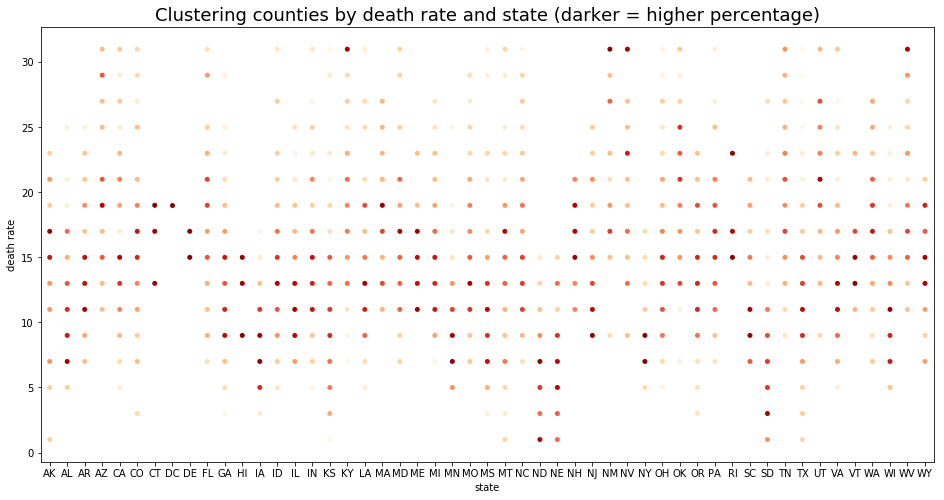

In [270]:
plt.rcParams["figure.figsize"] = [16.0, 8.0]
ax = sns.stripplot(data=counts, x='state', y='numeric', hue='percent', palette='OrRd')
ax.legend_.remove()
ax.set_title('Clustering counties by death rate and state (darker = higher percentage)', size=18)
ax.set_ylabel('death rate')

While there are some states with outlying concentrations of counties with low or high death rates, the distribution is fairly even overall.

In [271]:
data_31 = data.copy()
data = data[data['death_rate'] != '30+']

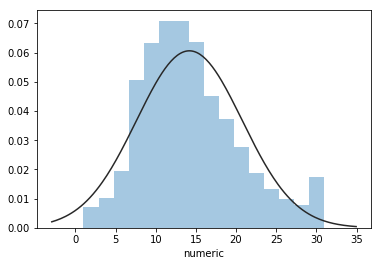

In [272]:
plt.rcParams["figure.figsize"] = [6.0, 4.0]
from scipy.stats import norm
sns.distplot(targets['numeric'], bins=16, fit=norm, kde=False)

The target distribution is not normal, but it follows the general shape of a normal curve except for the high-end spike at death_rate = 31. The class imbalance will have to be dealt with. 

In [273]:
bivariate = data.drop(['state', 'name', 'pop_2014', 'urban_influence'], axis=1).corr().abs()
print(bivariate)

               < diploma   degree+   pop_inc  foreign_inc  unemployment  \
< diploma       1.000000  0.590198  0.173795     0.014397      0.420872   
degree+         0.590198  1.000000  0.436721     0.037746      0.329834   
pop_inc         0.173795  0.436721  1.000000     0.001243      0.253635   
foreign_inc     0.014397  0.037746  0.001243     1.000000      0.003454   
unemployment    0.420872  0.329834  0.253635     0.003454      1.000000   
unemp_change    0.127994  0.117896  0.029990     0.003099      0.213587   
poverty         0.663283  0.447611  0.267106     0.014567      0.600237   
median_hh_inc   0.542180  0.680273  0.466601     0.018149      0.454140   
pov_change      0.043761  0.031475  0.047822     0.001281      0.202458   
median_age      0.221839  0.178017  0.364938     0.035829      0.061179   
hh_afr_am       0.363750  0.091370  0.102100     0.003461      0.422107   
hh_hisp         0.452917  0.020773  0.177056     0.001030      0.013150   
hh_female       0.546617 

**poverty** correlates strongly with a couple of other variables, so drop it. The two crime variables correlate strongly with each other, so combine them into one. 

In [274]:
data['crime'] = (data['viol_crime'] + data['prop_crime'])
data = data.drop(['viol_crime', 'prop_crime', 'poverty'], axis=1)

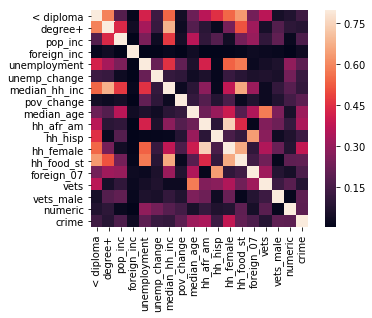

In [275]:
corrmat = data.drop(['state', 'name', 'urban_influence', 'pop_2014', 'death_rate'], axis=1).corr().abs()
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

There are still some strong correlations, but they are scattered. Use VIF analysis to programmatically eliminate the variables with the highest VIF scores until all scores are below 10, a conservative threshold.

In [276]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each column in features, calculate VIF and save in dataframe
vif = pd.DataFrame()
remove = ['state', 'name', 'urban_influence', 'pop_2014', 'death_rate', 'numeric']
features = data.drop(remove, axis=1)
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,23.727191,< diploma
1,19.038561,degree+
2,1.649532,pop_inc
3,1.022300,foreign_inc
4,16.496006,unemployment
5,4.113846,unemp_change
6,45.701203,median_hh_inc
7,1.217936,pov_change
8,151.793720,median_age
9,4.062589,hh_afr_am


In [277]:
max_VIF = max(vif['VIF'])
while max_VIF > 10:
    remove = remove + list(vif[vif['VIF'] == max_VIF]['features'])
    features = data.drop(remove, axis=1)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,7.393791,degree+
1,1.338485,pop_inc
2,1.021619,foreign_inc
3,3.636447,unemp_change
4,1.172304,pov_change
5,2.085686,hh_afr_am
6,2.688671,hh_hisp
7,5.496295,hh_food_st
8,3.662824,foreign_07
9,9.296857,vets


In [278]:
features1 = list(vif['features']) + ['urban_influence', 'death_rate']

In [279]:
data1 = data.loc[:, features1]

In [280]:
data1.describe()

,degree+,pop_inc,foreign_inc,unemp_change,pov_change,hh_afr_am,hh_hisp,hh_food_st,foreign_07,vets,crime,urban_influence
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,20.936456,0.003378,0.404249,2.961078,-0.553704,0.082971,0.059307,0.102264,4.292097,0.088620,0.020376,5.205688
std,9.154237,0.041861,3.094303,1.783505,2.141838,0.139566,0.111013,0.056556,5.528622,0.022547,0.013327,3.469448
min,2.985000,-0.177510,-6.333333,-8.200000,-15.900000,0.000000,0.000000,0.000000,0.000000,0.019065,0.000000,1.000000
25%,14.571000,-0.021187,0.008944,1.800000,-1.700000,0.002650,0.009731,0.061792,1.200000,0.074239,0.011210,2.000000
50%,18.640500,-0.003907,0.059489,2.800000,-0.500000,0.013880,0.020117,0.092311,2.300000,0.087297,0.018461,5.000000
75%,24.783250,0.020743,0.204738,4.000000,0.600000,0.098243,0.052727,0.132885,5.100000,0.100467,0.027261,8.000000
max,80.210000,0.727044,119.000000,13.600000,17.400000,0.832707,0.955767,0.399738,63.100000,0.297533,0.157014,12.000000


All of the features besides the categorical **urban_influence** have strong outliers, as can be seen from the min and max values compared to the IQR.

In [281]:
def get_outliers(df, multiplier=1.5):
    stats = df.describe()
    iqr = stats.loc['75%'] - stats.loc['25%']
    lower = stats.loc['25%'] - multiplier * iqr
    upper = stats.loc['75%'] + multiplier * iqr
    return ((df < lower) | (df > upper))

In [282]:
predictors = data1.drop('death_rate', axis=1)

outliers = get_outliers(predictors)
len(data1[outliers.any(axis=1)])

1349

More than 1/3 of the records contain outliers, using the standard definition.

In [283]:
strong_outliers = get_outliers(predictors, 2.0)
len(data1[strong_outliers.any(axis=1)])

1052

In [284]:
extreme_outliers = get_outliers(predictors, 2.5)
len(data1[extreme_outliers.any(axis=1)])

845

In [285]:
len(data1[extreme_outliers.sum(axis=1) > 1])

217

Removing even just the extreme outliers would take away almost 1/3 of the data, but removing records with 2 or more extreme outliers will reduce the dataset by only 7.5%. Try this first

In [286]:
data1 = data1.drop(data1[extreme_outliers.sum(axis=1) > 1].index)

In [287]:
len(data1)

2807

Try a range of classifiers. 

In [288]:
X1 = data1.drop('death_rate', axis=1)
X1 = pd.get_dummies(X1, prefix='urb_inf_', columns=['urban_influence'])
Y1 = data1.loc[:, 'death_rate']

In [289]:
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()

from sklearn.metrics import matthews_corrcoef, make_scorer
matthews = make_scorer(matthews_corrcoef)

from sklearn.model_selection import cross_val_score

In [290]:
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [291]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=.35, random_state=13, stratify=Y1)

In [293]:
knn = KNeighborsClassifier()
lrc = LogisticRegression(class_weight='balanced')
gbc = GradientBoostingClassifier()
sgd = SGDClassifier(class_weight='balanced', tol=1e-3)
rfc = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')

In [296]:
classifiers = [lrc, gbc, sgd, rfc, svc, knn]
names = ['Logistic regression', 'Gradient boosting', 'SGD', 'Random forest', 'Support vector', 'K-Nearest neighbors']

def run_trials(X, Y):
    for name, clf in zip(names, classifiers):
        %time cross_val_score(clf, robust.fit_transform(X), Y, scoring=matthews)
        scores = cross_val_score(clf, robust.fit_transform(X), Y, scoring=matthews)
        print('{} scores: {}'.format(name, scores))
        print('Average score: {}'.format(np.mean(scores)))

In [297]:
run_trials(X1_train, Y1_train)

CPU times: user 530 ms, sys: 10.5 ms, total: 541 ms
Wall time: 185 ms
Logistic regression scores: [ 0.03443237  0.05343197  0.05088997]
Average score: 0.046251435521370315
CPU times: user 9.02 s, sys: 38.6 ms, total: 9.06 s
Wall time: 8.53 s
Gradient boosting scores: [ 0.05046796  0.05770805  0.02212396]
Average score: 0.04343332451897247
CPU times: user 121 ms, sys: 2.25 ms, total: 124 ms
Wall time: 44.3 ms
SGD scores: [-0.00283388  0.02604344  0.01822471]
Average score: 0.013811424398263364
CPU times: user 564 ms, sys: 13.1 ms, total: 577 ms
Wall time: 146 ms
Random forest scores: [ 0.02594811  0.02878457  0.0434467 ]
Average score: 0.03272646137264382
CPU times: user 524 ms, sys: 2.15 ms, total: 527 ms
Wall time: 530 ms
Support vector scores: [ 0.03941453  0.0659676   0.06859878]
Average score: 0.05799363513685964
CPU times: user 87.3 ms, sys: 594 µs, total: 87.9 ms
Wall time: 88.5 ms
K-Nearest neighbors scores: [ 0.0461835   0.04728616  0.03039442]
Average score: 0.0412880272111412

All of the stock classifiers performed poorly. Try an alternative selection process starting with correlations with the target variable.

In [298]:
bivariate = data.drop(['state', 'name', 'pop_2014', 'urban_influence'], axis=1).corr().abs()
bivariate.loc['numeric']

< diploma        0.071415
degree+          0.095094
pop_inc          0.022837
foreign_inc      0.002764
unemployment     0.289674
unemp_change     0.235700
median_hh_inc    0.180909
pov_change       0.142860
median_age       0.056238
hh_afr_am        0.116110
hh_hisp          0.067249
hh_female        0.077653
hh_food_st       0.194698
foreign_07       0.049836
vets             0.182828
vets_male        0.013722
numeric          1.000000
crime            0.191859
Name: numeric, dtype: float64

In [299]:
features2 = list(bivariate[bivariate.loc['numeric'] > .05].index)
features2.remove('numeric')

In [300]:
vif = pd.DataFrame()
features = data.loc[:, features2]
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,18.400137,< diploma
1,15.395662,degree+
2,15.916503,unemployment
3,4.046981,unemp_change
4,34.719466,median_hh_inc
5,1.200618,pov_change
6,71.139734,median_age
7,3.671207,hh_afr_am
8,2.370453,hh_hisp
9,28.840613,hh_female


In [301]:
max_VIF = max(vif['VIF'])
while max_VIF > 10:
    remove = list(vif[vif['VIF'] == max_VIF]['features'])
    reduced = [feature for feature in features if feature not in remove]
    features = data.loc[:, reduced]
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,5.415383,degree+
1,3.569257,unemp_change
2,1.145696,pov_change
3,2.049218,hh_afr_am
4,1.447379,hh_hisp
5,5.283501,hh_food_st
6,8.603989,vets
7,4.206281,crime


(0, 0.2)

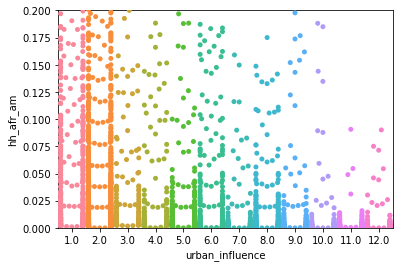

In [116]:
sns.swarmplot(y=data['hh_afr_am'], x=data['urban_influence'])
plt.ylim(0, .2)

(0, 0.2)

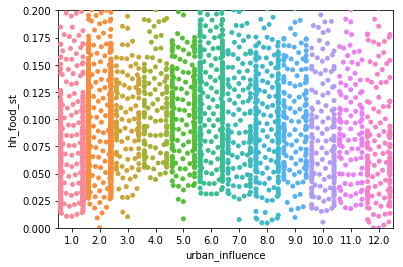

In [117]:
sns.swarmplot(y=data['hh_food_st'], x=data['urban_influence'])
plt.ylim(0,.2)

Patterns are apparent when lookiing at **urban_influence** vs. **hh_afr_am** and **hh_food_st** and could affect the results, especially with regard to **hh_afr_am**, but the relationships are complicated. There seems no reason to remove any of these features at this point.

In [302]:
features2 = list(vif['features'])
data2 = data.loc[:, features2]

In [303]:
outliers2 = get_outliers(data2)
len(data2[outliers2.any(axis=1)])

1074

In [304]:
strong_outliers2 = get_outliers(data2, 2.0)
len(data2[strong_outliers2.any(axis=1)])

767

In [305]:
extreme_outliers2 = get_outliers(data2, 2.5)
len(data2[extreme_outliers2.any(axis=1)])

579

In [122]:
len(data2[extreme_outliers2.sum(axis=1) > 1])

37

The number of samples with 2 or more extreme outliers is very small, so remove them.

In [306]:
#features2 = features2 + ['urban_influence', 'death_rate']
data2 = data.loc[:, features2 + ['urban_influence', 'death_rate']]
data2 = data2.drop(list(extreme_outliers2[extreme_outliers2.sum(axis=1) > 1].index))

In [307]:
len(data2)

2987

In [308]:
X2 = data2.drop('death_rate', axis=1)
X2 = pd.get_dummies(X2, prefix='urb_inf_', columns=['urban_influence'])
Y2 = data2.loc[:, 'death_rate']

In [309]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=.35, random_state=13, stratify=Y2)

In [314]:
run_trials(X2_train, Y2_train)

CPU times: user 464 ms, sys: 11.9 ms, total: 475 ms
Wall time: 164 ms
Logistic regression scores: [ 0.0653542   0.06426051  0.05446288]
Average score: 0.06135919647188473
CPU times: user 9.23 s, sys: 72.3 ms, total: 9.3 s
Wall time: 8.8 s
Gradient boosting scores: [ 0.00748213  0.03492783  0.03640778]
Average score: 0.026272579082859866
CPU times: user 207 ms, sys: 4.38 ms, total: 211 ms
Wall time: 71 ms
SGD scores: [ 0.02736852  0.05019458  0.03881846]
Average score: 0.03879385295205545
CPU times: user 571 ms, sys: 15.4 ms, total: 587 ms
Wall time: 149 ms
Random forest scores: [ 0.04205887  0.04637304  0.03085297]
Average score: 0.03976162525291876
CPU times: user 536 ms, sys: 1.33 ms, total: 537 ms
Wall time: 539 ms
Support vector scores: [ 0.09077613  0.07653431  0.06100204]
Average score: 0.07610416084229144
CPU times: user 75 ms, sys: 271 µs, total: 75.3 ms
Wall time: 75.3 ms
K-Nearest neighbors scores: [ 0.04922203  0.05342833  0.04492025]
Average score: 0.04919020524680038


The scores are significantly better for the best-performing algorithms (support vector and logistic regression), and only 37 outliers were dropped. Look at performance with all extreme outliers removed, since the total is only 2/3 the number with the first feature set.

In [311]:
data3 = data.loc[:, features2 + ['urban_influence', 'death_rate']]
data3 = data3.drop(list(extreme_outliers2[extreme_outliers2.any(axis=1)].index))

In [312]:
X3 = data3.drop('death_rate', axis=1)
X3 = pd.get_dummies(X3, prefix='urb_inf_', columns=['urban_influence'])
Y3 = data3.loc[:, 'death_rate']
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=.35, random_state=13, stratify=Y3)

In [313]:
run_trials(X3_train, Y3_train)

CPU times: user 367 ms, sys: 14.2 ms, total: 381 ms
Wall time: 131 ms
Logistic regression scores: [ 0.03824766  0.0527296   0.05058477]
Average score: 0.04718734470516132
CPU times: user 7.39 s, sys: 28 ms, total: 7.42 s
Wall time: 6.88 s
Gradient boosting scores: [ 0.05007863  0.03284422  0.04623312]
Average score: 0.043051992185583164
CPU times: user 167 ms, sys: 3.19 ms, total: 170 ms
Wall time: 59.8 ms
SGD scores: [ 0.03997794  0.03660005  0.01499438]
Average score: 0.03052412271725309
CPU times: user 491 ms, sys: 11.9 ms, total: 502 ms
Wall time: 127 ms
Random forest scores: [ 0.01780416  0.03702737  0.05219136]
Average score: 0.035674298821441436
CPU times: user 363 ms, sys: 597 µs, total: 364 ms
Wall time: 364 ms
Support vector scores: [ 0.05955823  0.04819215  0.06224929]
Average score: 0.05666656026190261
CPU times: user 66.8 ms, sys: 270 µs, total: 67.1 ms
Wall time: 67.1 ms
K-Nearest neighbors scores: [ 0.04391032  0.04042087  0.04513987]
Average score: 0.04315702109785544


With more outliers removed, performance is not as good. Use the second set minus the most extreme outliers, but combine to form fewer targets.  

In [315]:
Y2_16 = Y2.apply(lambda x: '0-1.9' if x == '<2' else x)

In [316]:
def combine_targets(input):
    targets = sorted(input.unique(), key=lambda x: int(re.search('\d+(?=-)', x).group()))
    first = []
    second = []
    for i, r in enumerate(targets):
        first.append(r) if i % 2 == 0 else second.append(r)
    if len(first) != len(second):
        second.append('30-31.9')
    conversions = {}
    for start, end in zip(first, second):
        new_value = re.search('\d+-', start).group() + re.search('(?<=-)\d+.\d+', end).group()
        conversions.update(dict.fromkeys([start, end], new_value))
    return input.apply(lambda x: conversions[x])

In [317]:
Y2_8 = combine_targets(Y2_16)

In [318]:
Y2_8_train = Y2_8[list(Y2_train.index)]
Y2_8_test = Y2_8[list(Y2_test.index)]

In [319]:
run_trials(X2_train, Y2_8_train)

CPU times: user 274 ms, sys: 8.26 ms, total: 282 ms
Wall time: 95.8 ms
Logistic regression scores: [ 0.13495088  0.16425267  0.1225845 ]
Average score: 0.14059601710547753
CPU times: user 4.71 s, sys: 30 ms, total: 4.74 s
Wall time: 4.22 s
Gradient boosting scores: [ 0.10847247  0.09842748  0.08183289]
Average score: 0.09624427946731955
CPU times: user 125 ms, sys: 2.45 ms, total: 128 ms
Wall time: 43.9 ms
SGD scores: [ 0.10304783  0.06768716  0.06989021]
Average score: 0.08020839873655088
CPU times: user 487 ms, sys: 10 ms, total: 497 ms
Wall time: 125 ms
Random forest scores: [ 0.11293203  0.12235713  0.04370716]
Average score: 0.09299877559666674
CPU times: user 469 ms, sys: 1.4 ms, total: 470 ms
Wall time: 472 ms
Support vector scores: [ 0.13318047  0.14307468  0.12523275]
Average score: 0.13382929923377543
CPU times: user 71.6 ms, sys: 110 µs, total: 71.7 ms
Wall time: 71.7 ms
K-Nearest neighbors scores: [ 0.0957713   0.06098616  0.06262617]
Average score: 0.07312787835971878


There was significant improvement, but performance is still poor. Try reducing to 4 classes.

In [320]:
Y2_4_train = combine_targets(Y2_8_train)
Y2_4_test = combine_targets(Y2_8_test)

In [321]:
run_trials(X2_train, Y2_4_train)

CPU times: user 176 ms, sys: 5.55 ms, total: 182 ms
Wall time: 59.6 ms
Logistic regression scores: [ 0.24084626  0.24144025  0.2268742 ]
Average score: 0.2363869043773474
CPU times: user 2.64 s, sys: 34.8 ms, total: 2.67 s
Wall time: 2.16 s
Gradient boosting scores: [ 0.23790672  0.26343635  0.17400427]
Average score: 0.22511577984629624
CPU times: user 90.7 ms, sys: 1.69 ms, total: 92.4 ms
Wall time: 32.4 ms
SGD scores: [ 0.16052502  0.16679329  0.16245597]
Average score: 0.16325809194848598
CPU times: user 419 ms, sys: 7.93 ms, total: 427 ms
Wall time: 107 ms
Random forest scores: [ 0.17421468  0.21594574  0.14400736]
Average score: 0.1780559259800176
CPU times: user 388 ms, sys: 2.18 ms, total: 390 ms
Wall time: 395 ms
Support vector scores: [ 0.2400265   0.20753516  0.20853107]
Average score: 0.21869757767825235
CPU times: user 72.2 ms, sys: 260 µs, total: 72.4 ms
Wall time: 72.4 ms
K-Nearest neighbors scores: [ 0.18547823  0.21382778  0.19031909]
Average score: 0.19654169790769171

In [322]:
Y2_2_train = combine_targets(Y2_4_train)
Y2_2_test = combine_targets(Y2_4_test)

In [323]:
run_trials(X2_train, Y2_2_train)

CPU times: user 30.1 ms, sys: 1.42 ms, total: 31.5 ms
Wall time: 30.3 ms
Logistic regression scores: [ 0.36626722  0.42487928  0.38697557]
Average score: 0.3927073577578684
CPU times: user 497 ms, sys: 2.51 ms, total: 500 ms
Wall time: 504 ms
Gradient boosting scores: [ 0.2943312   0.40709062  0.29013033]
Average score: 0.33051738236531564
CPU times: user 24.7 ms, sys: 314 µs, total: 25 ms
Wall time: 24.9 ms
SGD scores: [ 0.18661132  0.16180496  0.30498865]
Average score: 0.21780164349143427
CPU times: user 95.3 ms, sys: 213 µs, total: 95.5 ms
Wall time: 95.5 ms
Random forest scores: [ 0.22846365  0.29330825  0.28611493]
Average score: 0.26929560743736336
CPU times: user 229 ms, sys: 952 µs, total: 230 ms
Wall time: 231 ms
Support vector scores: [ 0.33687477  0.43596485  0.4040663 ]
Average score: 0.39230197448291687
CPU times: user 69.4 ms, sys: 365 µs, total: 69.8 ms
Wall time: 69.9 ms
K-Nearest neighbors scores: [ 0.28190545  0.36722807  0.22763312]
Average score: 0.2922555465753007

In [324]:
svc.fit(robust.fit_transform(X2_train), Y2_2_train)
matthews_corrcoef(Y2_2_test, svc.predict(robust.fit_transform(X2_test)))

0.41847912457764941

In [325]:
lrc.fit(robust.fit_transform(X2_train), Y2_2_train)
matthews_corrcoef(Y2_2_test, lrc.predict(robust.fit_transform(X2_test)))

0.37060868281691173

Support vector performs better on the test set, but logistic regression is more interpretable, so optimize both. A quick check of results with and without the **30+** target values showed that the model performs better with them included, so leave them in.

In [326]:
binary = data_31.copy()
binary['crime'] = (binary['viol_crime'] + binary['prop_crime'])
binary = binary.drop(['viol_crime', 'prop_crime', 'urban_influence'], axis=1)
binary = binary.loc[:, features2]

extreme_outliers3 = get_outliers(binary, 2.5)

binary['urban_influence'] = data_31['urban_influence']
binary['high_death_rate'] = np.where(data_31['numeric'] > 15, 1, 0)

binary = binary.drop(list(extreme_outliers3[extreme_outliers3.sum(axis=1) > 1].index))


In [327]:
X = binary.drop('high_death_rate', axis=1)
X = pd.get_dummies(X, prefix='urb_inf_', columns=['urban_influence'])
Y = binary.loc[:, 'high_death_rate']

In [328]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [329]:
def optimize(clf, params, X, Y, t_size, rand):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=t_size, random_state=rand, stratify=Y)
    model = GridSearchCV(clf, param_grid=params, scoring=matthews)
    model.fit(robust.fit_transform(X_train), Y_train)
    print('Optimal parameters: {}'.format(model.best_params_))
    Xr_test = robust.fit_transform(X_test)
    preds = model.predict(Xr_test)
    print('Matthews score: {}'.format(matthews_corrcoef(Y_test, preds)))
    print('ROC-AUC score: {}'.format(roc_auc_score(Y_test, preds)))
    print(confusion_matrix(Y_test, preds))
    residuals = pd.DataFrame(model.best_estimator_.decision_function(Xr_test))
    plt.scatter(residuals.index, residuals)
    return model

In [330]:
lrc_params = [{ 'penalty': ['l1', 'l2'], 'tol': [1e-4, 1e-3], 'C': [1e-2, 1e-1, 1, 2, 3, 4, 5],
               'solver': ['liblinear'], 'multi_class': ['ovr']},
            { 'penalty': ['l2'], 'tol': [1e-4, 1e-3], 'C': [1e-2, 1e-1, 1, 2, 3, 4, 5],
             'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}]

# The sag and saga solvers did not converge, and neither did the other solvers for tolerance values below .0001

Optimal parameters: {'C': 1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
Matthews score: 0.34317588938349153
ROC-AUC score: 0.6808252427184466
[[279 133]
 [ 65 141]]


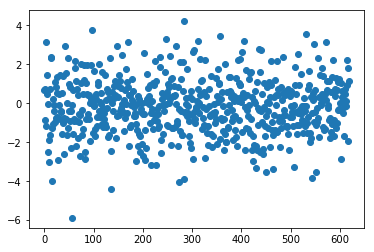

In [331]:
lrc_1 = optimize(lrc, lrc_params, X, Y, 0.2, 13)

Optimal parameters: {'C': 5, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.3708142160452492
ROC-AUC score: 0.6953883495145631
[[283 129]
 [ 61 145]]


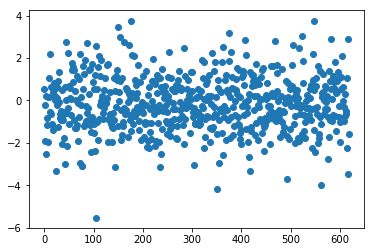

In [332]:
lrc_2 = optimize(lrc, lrc_params, X, Y, 0.2, 37)

A different data split results in different optimal values for C and the penalty, as well as significantl differences in the scores, indicating potential instabillity. But the confusion matrices show the models consistently performing fairly well on classifying the high death rates and very poorly on the low death rates. In both cases the residuals are evenly distributed around 0.  

In [333]:
svc_params = {'C': [0.5, 1, 4, 7], 'kernel': ['linear', 'poly', 'rbf'],
             'gamma': [0.1, 0.12, 0.14], 'tol': [1e-7, 5e-7, 1e-6, 5e-6]}

Optimal parameters: {'C': 1, 'gamma': 0.14, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.43405167074723355
ROC-AUC score: 0.7281553398058253
[[296 116]
 [ 54 152]]


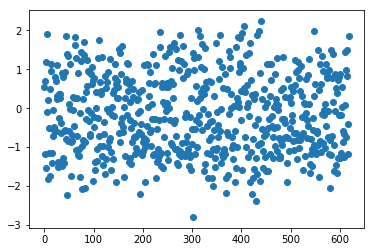

In [334]:
svc_1 = optimize(svc, svc_params, X, Y, .2, 13)

Optimal parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.43405167074723355
ROC-AUC score: 0.7281553398058253
[[296 116]
 [ 54 152]]


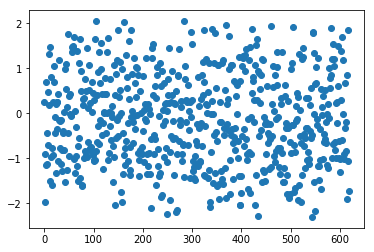

In [335]:
svc_2 = optimize(svc, svc_params, X, Y, .2, 37)

The support vector model is extremely stable, with exactly the same performance and the same optimal parameter selection, with the minor exception of slightly different values for the gamma parameter. (The residuals plots also show differences.) As with the logistic regression, the residuals plot does not show heteroscedasticity, and the values are concentrated in a narrower band around 0.

Optimal parameters: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.31603366505385294
ROC-AUC score: 0.6674757281553397
[[260 152]
 [ 61 145]]


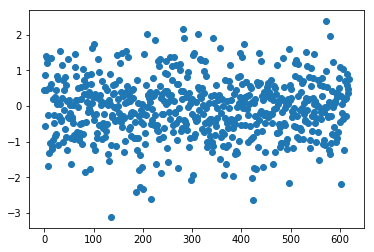

In [336]:
X_mod = X.drop('hh_afr_am', axis=1)
lrc_3 = optimize(lrc, lrc_params, X_mod, Y, 0.2, 13)

Optimal parameters: {'C': 0.01, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.2918237357523379
ROC-AUC score: 0.654126213592233
[[267 145]
 [ 70 136]]


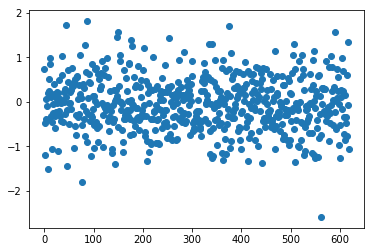

In [337]:
lrc_4 = optimize(lrc, lrc_params, X_mod, Y, 0.2, 37)

The model is neither more accurate nor more stable with **hh_afr_am** removed to reduce possible interdependence between **urb_inf_1.0** and **urb_inf_2.0**.

In [338]:
feature_rank = zip(X.columns, lrc_1.best_estimator_.coef_[0])
results = sorted(feature_rank, key=lambda tup: tup[1], reverse=True)
for f, r in results:
    print('{:13.12}: {:8.5f}  OR:{:5.2f} '.format(f, r, np.exp(r)))

hh_food_st   :  1.27318  OR: 3.57 
urb_inf__1.0 :  0.79387  OR: 2.21 
crime        :  0.71185  OR: 2.04 
unemp_change :  0.47654  OR: 1.61 
vets         :  0.44686  OR: 1.56 
urb_inf__4.0 :  0.24938  OR: 1.28 
urb_inf__7.0 :  0.20862  OR: 1.23 
urb_inf__11. :  0.19365  OR: 1.21 
urb_inf__10. :  0.08687  OR: 1.09 
degree+      :  0.02245  OR: 1.02 
urb_inf__12. :  0.01171  OR: 1.01 
urb_inf__2.0 :  0.00000  OR: 1.00 
urb_inf__3.0 : -0.01195  OR: 0.99 
hh_hisp      : -0.07687  OR: 0.93 
urb_inf__9.0 : -0.20690  OR: 0.81 
pov_change   : -0.30001  OR: 0.74 
urb_inf__6.0 : -0.44885  OR: 0.64 
urb_inf__8.0 : -0.51866  OR: 0.60 
hh_afr_am    : -0.77975  OR: 0.46 
urb_inf__5.0 : -1.01080  OR: 0.36 


In [339]:
feature_rank = zip(X.columns, lrc_2.best_estimator_.coef_[0])
results = sorted(feature_rank, key=lambda tup: tup[1], reverse=True)
for f, r in results:
    print('{:13.12}: {:8.5f}  OR:{:5.2f} '.format(f, r, np.exp(r)))

hh_food_st   :  1.21741  OR: 3.38 
urb_inf__1.0 :  0.78258  OR: 2.19 
crime        :  0.70416  OR: 2.02 
vets         :  0.49870  OR: 1.65 
unemp_change :  0.44148  OR: 1.56 
urb_inf__4.0 :  0.38698  OR: 1.47 
urb_inf__7.0 :  0.37549  OR: 1.46 
urb_inf__10. :  0.29877  OR: 1.35 
urb_inf__11. :  0.12761  OR: 1.14 
urb_inf__12. :  0.09120  OR: 1.10 
degree+      :  0.07712  OR: 1.08 
urb_inf__3.0 :  0.07070  OR: 1.07 
urb_inf__2.0 :  0.02939  OR: 1.03 
hh_hisp      : -0.06478  OR: 0.94 
urb_inf__9.0 : -0.24495  OR: 0.78 
urb_inf__6.0 : -0.30039  OR: 0.74 
pov_change   : -0.30220  OR: 0.74 
urb_inf__8.0 : -0.56345  OR: 0.57 
hh_afr_am    : -0.69317  OR: 0.50 
urb_inf__5.0 : -1.01703  OR: 0.36 


In [340]:
full = data_31.copy()
full['crime'] = (full['viol_crime'] + full['prop_crime'])
full = full.drop(['state', 'name', 'urban_influence', 'pop_2014', 'viol_crime', 'prop_crime',
                  'death_rate', 'numeric'], axis=1)

extreme_outliers4 = get_outliers(full, 2.5)



In [341]:
len(extreme_outliers4[extreme_outliers4.sum(axis=1) > 1])

278

In [342]:
full['urban_influence'] = data_31['urban_influence']
full['high_death_rate'] = np.where(data_31['numeric'] > 15, 1, 0)

full = full.drop(list(extreme_outliers4[extreme_outliers4.sum(axis=1) > 1].index))

In [343]:
X_full = full.drop('high_death_rate', axis=1)
X_full = pd.get_dummies(X_full, prefix='urb_inf_', columns=['urban_influence'])
Y_full = full.loc[:, 'high_death_rate']

Optimal parameters: {'C': 3, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.4720192244255177
ROC-AUC score: 0.7448680351906158
[[278  94]
 [ 51 147]]


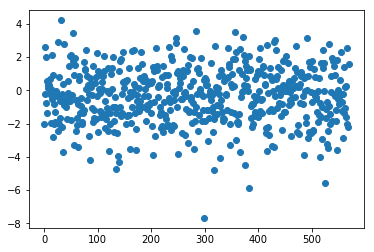

In [344]:
lrc_full_1 = optimize(lrc, lrc_params, X_full, Y_full, 0.2, 13)

Optimal parameters: {'C': 3, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.4115953413228014
ROC-AUC score: 0.7128950798305638
[[273  99]
 [ 61 137]]


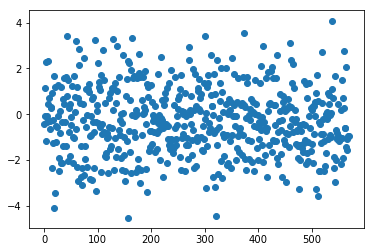

In [345]:
lrc_full_2 = optimize(lrc, lrc_params, X_full, Y_full, 0.2, 37)

In [350]:
def run_clf(estimator, X, Y, rand):
    clf = estimator
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=rand, stratify=Y)
    clf.fit(robust.fit_transform(X_train), Y_train)
    Xr_test = robust.fit_transform(X_test)
    preds = clf.predict(Xr_test)
    print('Matthews score: {}'.format(matthews_corrcoef(Y_test, preds)))
    print('ROC-AUC score: {}'.format(roc_auc_score(Y_test, preds)))
    print(confusion_matrix(Y_test, preds))
    residuals = pd.DataFrame(clf.decision_function(Xr_test))
    plt.scatter(residuals.index, residuals)
    return clf

Matthews score: 0.4917973754798792
ROC-AUC score: 0.7522401433691757
[[291  81]
 [ 55 143]]


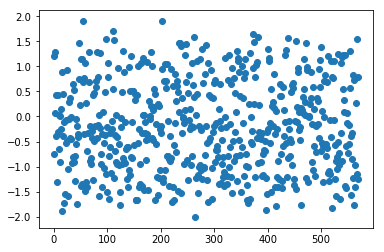

In [347]:
svc_full = SVC(class_weight='balanced', C=1, gamma=0.14, kernel='rbf', tol=1e-07)
svc_full_1 = run_clf(svc_full, X_full, Y_full, 13)

Matthews score: 0.4479352601144688
ROC-AUC score: 0.7291870316063864
[[287  85]
 [ 62 136]]


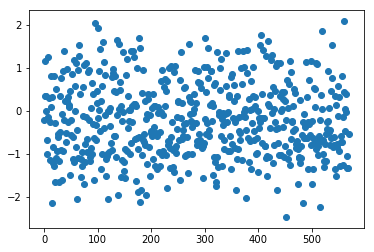

In [348]:
svc_full = SVC(class_weight='balanced', C=1, gamma=0.1, kernel='rbf', tol=1e-07)
svc_full_2 = run_clf(svc_full, X_full, Y_full, 37)

Using all the features can produce higher test scores, but the models are unstable. The support vector model with the reduced feature set is the best model.

Matthews score: 0.35868040361097553
ROC-AUC score: 0.6893203883495145
[[278 134]
 [ 61 145]]


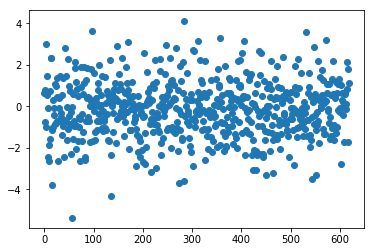

In [351]:
svc_linear = SVC(class_weight='balanced', C=1, gamma=0.14, kernel='linear', tol=1e-07)
svc_linear_1 = run_clf(svc_linear, X, Y, 13)

In [353]:
feature_rank = zip(X.columns, svc_linear_1.coef_[0])
results = sorted(feature_rank, key=lambda tup: tup[1], reverse=True)
for f, r in results:
    print('{:13.12}: {:8.5f}'.format(f, r))

hh_food_st   :  1.24584
urb_inf__1.0 :  0.78564
crime        :  0.65873
unemp_change :  0.51451
vets         :  0.46265
urb_inf__11. :  0.43960
urb_inf__4.0 :  0.33089
urb_inf__7.0 :  0.18993
urb_inf__10. :  0.13090
urb_inf__12. :  0.10159
degree+      :  0.06550
urb_inf__2.0 :  0.05489
hh_hisp      : -0.06656
urb_inf__3.0 : -0.08929
urb_inf__9.0 : -0.13607
pov_change   : -0.28479
urb_inf__6.0 : -0.39420
urb_inf__8.0 : -0.41333
hh_afr_am    : -0.71714
urb_inf__5.0 : -1.00056


The linear kernel does not give optimal performance, but it does provide feature coefficients. The ranking is almost identical to that obtained from the optimized logistic regression model.